# Point alignment with SVD (a step in the Iterative Closest Points algorithm)

First, we define $P$ and $X$ as $2 \times N$ matrices; the $i$-th column contains the $x,y$ coordinates of one point $X_i$ and its correspondence $P_i$.  Note that the points are already matched.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

P = np.array([[0,0],[1,0],[2,0],[3,1]]).T
X = np.array([[2,1],[2,2],[2,3],[1,4]]).T
P = P + np.random.randn(*P.shape) * 0.1

Let's now draw our points and their correspondences

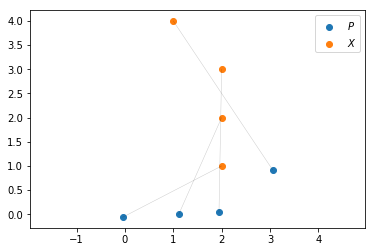

In [2]:
def plotpoints(P,X):
    fig,ax = plt.subplots()
    ax.scatter(P[0,:],P[1,:], label = "$P$")
    ax.scatter(X[0,:],X[1,:], label = "$X$")
    ax.plot(np.vstack((P[0,:],X[0,:])),np.vstack((P[1,:],X[1,:])),
           color = "black", linewidth = 0.5, alpha = 0.2)
    ax.axis("equal")
    plt.legend();
    
plotpoints(P,X)

## Step 1
We now compute the barycenter of both point clouds and subtract it to get $P'$ and $X'$

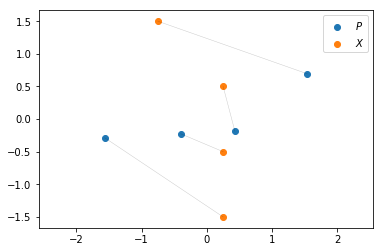

In [3]:
muP = np.mean(P, axis=1, keepdims=True)
muX = np.mean(X, axis=1, keepdims=True)
Pprime = P - muP
Xprime = X - muX
plotpoints(Pprime, Xprime)

## Step 2
We compute $W$ on which the SVD will be applied, as $W = \sum_{i = 1}^N x_i' p_i'^T$; this assumes $x_i'$ and $p_i'$ are column vectors, so $W$ will have size $2 \times 2$.

In [4]:
W = np.zeros((2,2))
for i in range(P.shape[1]):
    W += Xprime[:,[i]] @ Pprime[:,[i]].T
W

# or equivalently (not obvious why, have a look at the docs of np.dot)
# W = np.dot(Xprime, Pprime.T)

array([[-1.53899981, -0.69460679],
       [ 5.07324942,  1.49244616]])

## Step 3
We decompose $W = USV$ and recover the rigid transform as a rotation matrix $R = UV^T$ and a translation vector $t$

In [5]:
U,S,V = np.linalg.svd(W)
R = U @ V.T
t = muX - (R @ muP)

Let's double check that the $R$ matrix we got is a rotation matrix: rotation matrices have [special properties](https://en.wikipedia.org/wiki/Rotation_matrix#Properties_of_a_rotation_matrix); we check some of those below.

In [6]:
print(R)
assert(np.allclose(np.linalg.inv(R),R.T)) # R^-1 == R^T
assert(np.isclose(np.dot(R[0,:], R[1,:]), 0)) # rows should be orthogonal
assert(np.isclose(np.linalg.det(R), 1)) # determinant should be +1

[[-0.00807096 -0.99996743]
 [ 0.99996743 -0.00807096]]


We can now transform $P$ to align it to $X$

In [7]:
Paligned = R @ P + t
Paligned

array([[ 2.04935548,  1.97762721,  1.93002268,  1.04299463],
       [ 0.93668991,  2.09892502,  2.93104153,  4.03334354]])

In [8]:
# Same thing using homoegeneous coordinates
hmatrix = np.vstack((np.hstack((R,t)),[0,0,1]))
hP = np.vstack((P,np.ones(P.shape[1])))
hPaligned = hmatrix @ hP
Paligned = hPaligned[0:2,:]
Paligned

array([[ 2.04935548,  1.97762721,  1.93002268,  1.04299463],
       [ 0.93668991,  2.09892502,  2.93104153,  4.03334354]])

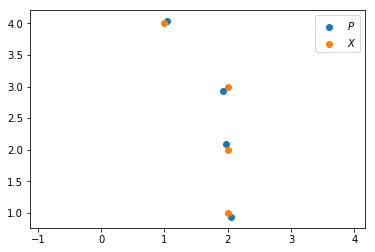

In [9]:
plotpoints(Paligned,X)